# 02: Geoprocessing


## imports


In [1]:
import pyogrio as ogr
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap

# done
# spatial join
# buildings to tax lots
# buildings in 3d with lonboard
# dissolve tax lot by lu or by owner

# not done
# union tax lots and sidewalk to get blocks in total
# intersect to show non-building area
# calculate soft site potential based on FAR, lot size, building class

In [2]:
cb_307 = ogr.read_dataframe(
    "../Data/nyc_mappluto_24v1_1_shp/mappluto_ogr.fgb", where="CD = 307"
)

<Axes: >

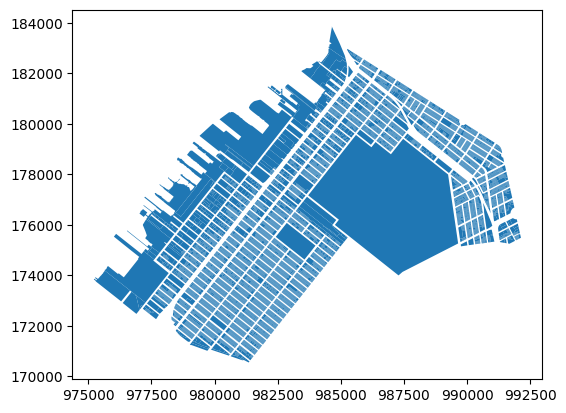

In [3]:
cb_307.plot()

In [4]:
# get maximum bounding geometry for all tax lots
bounds = cb_307.total_bounds

In [5]:
bounds_poly = gpd.GeoSeries(
    Polygon(
        [
            [bounds[0], bounds[1]],
            [bounds[0], bounds[3]],
            [bounds[2], bounds[3]],
            [bounds[2], bounds[1]],
            [bounds[0], bounds[1]],
        ]
    )
)

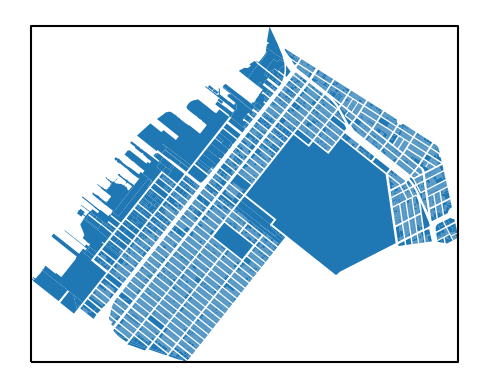

In [6]:
ax = cb_307.plot()
bounds_poly.boundary.plot(ax=ax, color="black").set_axis_off()

In [7]:
bounds_poly

0    POLYGON ((975222.902 170552.422, 975222.902 18...
dtype: geometry

In [8]:
bounds_poly.crs = cb_307.crs

In [9]:
bounds_poly.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## reproject


In [10]:
bounds_poly_wgs84 = bounds_poly.to_crs("EPSG:4326")

In [11]:
cb_307_bldgs = ogr.read_dataframe(
    "../Data/bldg_footprints/Building Footprints.geojson",
    mask=bounds_poly_wgs84[0],
)

<Axes: >

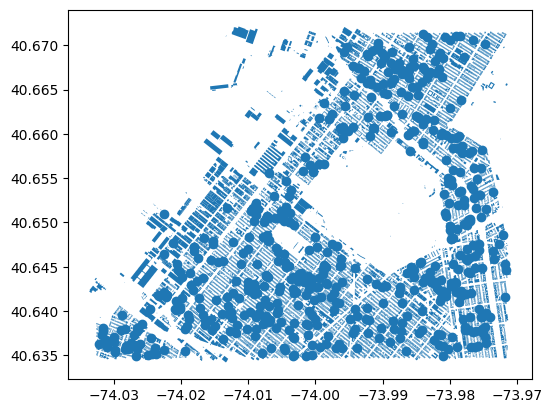

In [12]:
cb_307_bldgs.plot()

In [13]:
cb_307_bldgs = cb_307_bldgs[cb_307_bldgs.geometry.type != "Point"]

<Axes: >

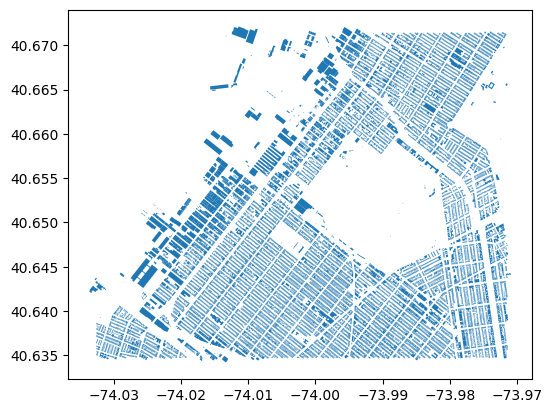

In [14]:
cb_307_bldgs.plot()

In [15]:
cb_307_bldgs = cb_307_bldgs.to_crs(cb_307.crs)

## spatial join


In [16]:
cb_307_bldgs["rep_pt"] = cb_307_bldgs.representative_point()
cb_307_bldgs.set_geometry("rep_pt", inplace=True)

In [17]:
cb_307_bldgs.base_bbl.nunique(), cb_307_bldgs.shape[0], cb_307_bldgs.globalid.nunique()

(26357, 30113, 30113)

In [18]:
cb_307_bldgs

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,globalid,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,rep_pt
0,None,3008130054,0.0,31.05,3008130054,1901,{C2B6150A-AA05-4865-B836-9DFA5C153E9C},Constructed,2100,48,Photogramm,3014166,2017-08-22,392052,0.0,"MULTIPOLYGON (((979424.884 174653.762, 979393....",POINT (979402.531 174638.900)
1,None,3010120038,0.0,42.44,3010120038,1921,{65E24ABD-485B-4B01-B70E-5ACA0E221B53},Constructed,2100,115,Photogramm,3022371,2017-08-22,743038,0.0,"MULTIPOLYGON (((989250.122 182249.393, 989226....",POINT (989230.470 182235.219)
2,None,3053130127,0.0,26.38239517,3053130127,1940,{454D03AE-5F41-4886-A5C5-74DD122005EF},Constructed,2100,57,Photogramm,3123939,2017-08-22,785686,0.0,"MULTIPOLYGON (((989342.250 173309.206, 989328....",POINT (989345.270 173325.920)
3,None,3058710090,0.0,24.71,3058710090,1920,{F02017F9-C56E-4793-96D1-03741F2569AC},Constructed,2100,73,Photogramm,3145644,2017-08-22,560761,0.0,"MULTIPOLYGON (((976372.261 170905.430, 976404....",POINT (976382.124 170892.831)
4,None,3058850095,0.0,26.79,3058850095,1925,{D97E7A81-466F-47F7-9159-D52052EC7129},Constructed,2100,68,Photogramm,3146300,2017-08-22,541427,0.0,"MULTIPOLYGON (((975991.817 170852.230, 975985....",POINT (975969.477 170848.875)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30108,None,3007280070,0.0,32.32698744,3007280070,2024,{7B705FF4-ACD6-45CD-A2E0-C32B7F74C263},Constructed,2100,39,Photogramm,3424568,2024-05-06,1302014,0.0,"MULTIPOLYGON (((981341.775 176474.519, 981329....",POINT (981321.248 176478.339)
30109,None,3007280071,0.0,32.32698744,3007280071,2024,{75A668C9-C3C1-4D26-A670-0BD6A433B4BB},Constructed,2100,39,Photogramm,3424569,2024-05-06,1302015,0.0,"MULTIPOLYGON (((981352.745 176488.370, 981341....",POINT (981333.527 176493.843)
30110,None,3056280026,0.0,62.045557,3056280026,2024,{BFFCEC04-59C1-42BF-97DD-F15B73596D1A},Constructed,2100,56,Photogramm,3429745,2024-05-06,1302016,0.0,"MULTIPOLYGON (((986534.944 171176.810, 986476....",POINT (986498.863 171161.133)
30111,None,3008290016,0.0,50.0,3008290016,2023,{A2C9A5C4-FDE4-4561-911C-635B8593DC2B},Constructed,2100,41,Other (Man,3428542,2024-05-06,1300421,0.0,"MULTIPOLYGON (((978919.968 174549.012, 978952....",POINT (978917.743 174512.745)


In [19]:
## spatial join buildings to tax lots based on building representative point
bldgs_w_lot = cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]].sjoin(
    cb_307, how="inner", op="within"
)

/Users/marioag/opt/anaconda3/envs/cdp/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
bldgs_w_lot_nearest = cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]].sjoin_nearest(
    cb_307, how="left", distance_col="distance"
)

<Axes: >

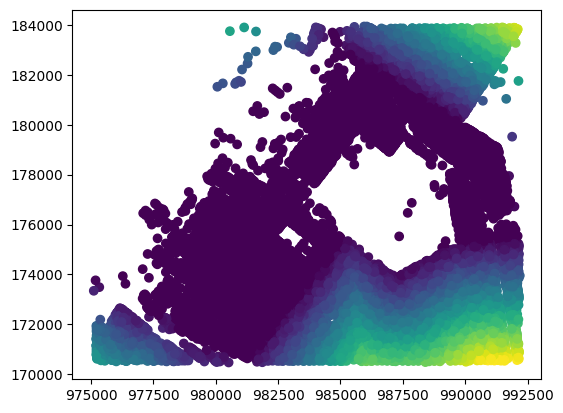

In [21]:
bldgs_w_lot_nearest.plot("distance")

<Axes: >

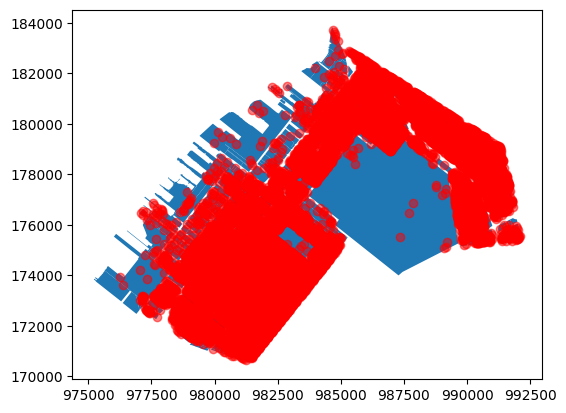

In [22]:
ax = cb_307.plot()
bldgs_w_lot.plot(ax=ax, color="red", alpha=0.5)

In [23]:
## drop cases where there is no match (i.e. no tax lot for buildings)

In [24]:
# now, join back to original building footprints
bldgs_w_lot = bldgs_w_lot.drop(columns=["rep_pt"]).merge(
    cb_307_bldgs, on="globalid", how="left"
)

In [25]:
bldgs_w_lot_gdf = gpd.GeoDataFrame(bldgs_w_lot, geometry="geometry")

In [26]:
cmap = {
    "One & Two Family Buildings": "#ff0000",
    "Multi-Family Walk-Up Buildings": "#00ff00",
    "Multi-Family Elevator Buildings": "#0000ff",
    "Mixed Residential & Commercial Buildings": "#ff00ff",
    "Commercial & Office Buildings": "#00ffff",
    "Industrial & Manufacturing": "#ffff00",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#800000",
    "Open Space & Outdoor Recreation": "#008000",
    "Parking Facilities": "#000080",
    "Vacant Land": "#800080",
    "Unknown": "#000000",
}

In [27]:
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

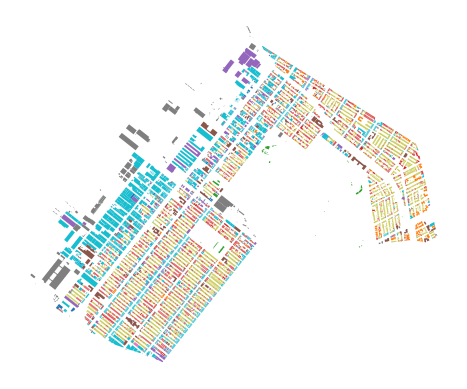

In [28]:
bldgs_w_lot_gdf.plot(column="color", legend=False).set_axis_off()

In [29]:
bldgs_w_lot_gdf.fillna({"LandUse": "Unknown"}, inplace=True)

In [30]:
cmap_rgb

{'One & Two Family Buildings': [255, 0, 0],
 'Multi-Family Walk-Up Buildings': [0, 255, 0],
 'Multi-Family Elevator Buildings': [0, 0, 255],
 'Mixed Residential & Commercial Buildings': [255, 0, 255],
 'Commercial & Office Buildings': [0, 255, 255],
 'Industrial & Manufacturing': [255, 255, 0],
 'Transportation & Utility': [128, 128, 128],
 'Public Facilities & Institutions': [128, 0, 0],
 'Open Space & Outdoor Recreation': [0, 128, 0],
 'Parking Facilities': [0, 0, 128],
 'Vacant Land': [128, 0, 128],
 'Unknown': [0, 0, 0]}

In [31]:
# make a lonboard plot with color based on land use and height based on number of floors
heights = bldgs_w_lot_gdf["heightroof"].astype(float).to_numpy()
bldgs_layer = PolygonLayer.from_geopandas(
    bldgs_w_lot_gdf[["geometry", "LandUse"]],
    get_fill_color=apply_categorical_cmap(bldgs_w_lot_gdf["LandUse"], cmap=cmap_rgb),
    extruded=True,
    get_elevation=heights,
)

m = Map(
    [bldgs_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459406,
        "longitude": -74.0151512,
    },
)
m

/Users/marioag/opt/anaconda3/envs/cdp/lib/python3.11/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x1486c79a0>
[
  31.05…

## attribute join


... sometimes it makes more sense to join based on attributes rather than spatial relationships. This is one of those cases.


In [32]:
cb_307_bldgs.mpluto_bbl.nunique(), cb_307.shape

(26320, (13284, 97))

In [33]:
cb_307.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [34]:
cb_307_bldgs.mpluto_bbl.dtype, cb_307.BBL.dtype

(dtype('O'), dtype('float64'))

In [35]:
cb_307_bldgs["mpluto_bbl"] = cb_307_bldgs["mpluto_bbl"].astype(float)

In [36]:
bldgs_w_lot_attrib = cb_307_bldgs.merge(
    cb_307, left_on="mpluto_bbl", right_on="BBL", how="inner"
)

In [73]:
# assert bldgs_w_lot_attrib.shape == bldgs_w_lot_gdf.shape
bldgs_w_lot_attrib.shape == bldgs_w_lot_gdf.shape

False

<Axes: >

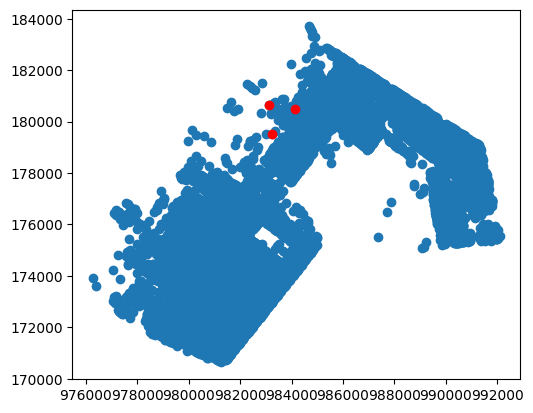

In [38]:
# find the globalid of the buildings in bldgs_w_lot_attrib that are not in bldgs_w_lot_gdf
ax = bldgs_w_lot_attrib.plot()
bldgs_w_lot_attrib[~bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)].plot(
    ax=ax, color="red"
)

In [39]:
missing_buildings = bldgs_w_lot_attrib[
    ~bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)
].globalid.unique()

In [40]:
bldgs_w_lot_attrib["geometry"] = bldgs_w_lot_attrib["geometry_x"]

In [41]:
bldgs_w_lot_attrib.set_geometry("geometry", inplace=True)

### investigate- what's going on??


In [42]:
# make a lonboard plot with color based on land use and height based on number of floors

missing_bldgs = bldgs_w_lot_attrib[bldgs_w_lot_attrib.globalid.isin(missing_buildings)]

heights_missing = missing_bldgs["heightroof"].astype(float).to_numpy()

lots_layer = PolygonLayer.from_geopandas(
    cb_307[["geometry", "LandUse"]],
    get_fill_color=apply_categorical_cmap(cb_307["LandUse"], cmap=cmap_rgb),
)

missing_bldgs_layer = PolygonLayer.from_geopandas(
    missing_bldgs[["geometry", "LandUse"]],
    get_fill_color=[255, 0, 0, 155],
    extruded=True,
    get_elevation=heights_missing,
)

m = Map(
    [missing_bldgs_layer, lots_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459406,
        "longitude": -74.0151512,
    },
)
m

/Users/marioag/opt/anaconda3/envs/cdp/lib/python3.11/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")
/Users/marioag/opt/anaconda3/envs/cdp/lib/python3.11/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x1454bd000>
[
  14.24…

So we can see that there are three cases where buildings are associated with lots, even if their representative point (or entire geometry) fall outside of the actual polygon.


## dissolve


Learn more about dissolve here: https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html


In [43]:
cb_307_by_owner = cb_307.dissolve(
    by="OwnerName",
    aggfunc={
        "LandUse": list,
        "LotArea": "sum",
    },
).reset_index()

Text(0.5, 1.0, 'Top 10 Owners by Lot Area')

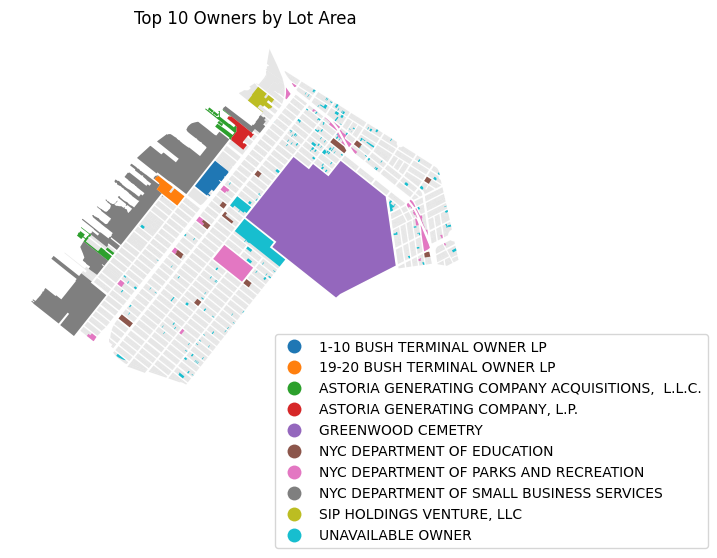

In [44]:
fig, ax = plt.subplots()
cb_307.plot(color="#cecece", ax=ax, alpha=0.5)

cb_307_by_owner.sort_values("LotArea", ascending=False).head(10).plot(
    column="OwnerName", legend=True, ax=ax
).set_axis_off()


# get legend item
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.0, 0.0, 0.5, 0.2))
ax.set_title("Top 10 Owners by Lot Area")
# put legend off the plot
# cb_307_by_owner.plot(column="OwnerName", legend=False)

In [45]:
cb_307_by_owner

,OwnerName,geometry,LandUse,LotArea
0,*** NO OWNER FOUND ***,"POLYGON ((980590.724 174235.587, 980527.813 17...",[One & Two Family Buildings],2003
1,1-10 BUSH TERMINAL OWNER LP,"POLYGON ((982202.987 178074.791, 982200.638 17...","[Commercial & Office Buildings, Industrial & M...",722097
2,10 E 4TH STREET LLC,"POLYGON ((990181.201 176930.755, 990282.152 17...",[Multi-Family Walk-Up Buildings],2050
3,10-16 OCEAN REALTIES,"POLYGON ((991792.749 176633.932, 991787.150 17...",[Multi-Family Elevator Buildings],42968
4,100 19TH STREET,"POLYGON ((989711.736 177970.244, 989649.158 17...",[Multi-Family Walk-Up Buildings],6010
...,...,...,...,...
12136,"ZWERLING, CARA","POLYGON ((990576.588 178737.293, 990630.331 17...",[One & Two Family Buildings],2000
12137,"ZWICK, ELAINE R","POLYGON ((990085.407 178976.260, 990103.152 17...",[Multi-Family Walk-Up Buildings],2000
12138,ZWL REALTY LLC,"POLYGON ((983015.618 174308.387, 982951.592 17...",[Multi-Family Walk-Up Buildings],2003
12139,ZY MANAGEMENT LLC,"POLYGON ((981487.360 171696.522, 981474.555 17...",[Mixed Residential & Commercial Buildings],2017


## Intersect / Difference


In [46]:
sample_block = cb_307.Block.sample(1).values[0]

In [47]:
sample_block

1056

In [48]:
cb_307_bldgs.columns

Index(['name', 'base_bbl', 'shape_area', 'heightroof', 'mpluto_bbl',
       'cnstrct_yr', 'globalid', 'lststatype', 'feat_code', 'groundelev',
       'geomsource', 'bin', 'lstmoddate', 'doitt_id', 'shape_len', 'geometry',
       'rep_pt'],
      dtype='object')

In [49]:
sample_block_lots = cb_307[cb_307.Block.eq(sample_block)].copy()
sample_block_bldgs = cb_307_bldgs[
    cb_307_bldgs.mpluto_bbl.isin(sample_block_lots.BBL.unique())
].copy()

In [50]:
sample_block_bldgs.set_geometry("geometry", inplace=True)

Text(0.5, 1.0, 'Block 1056')

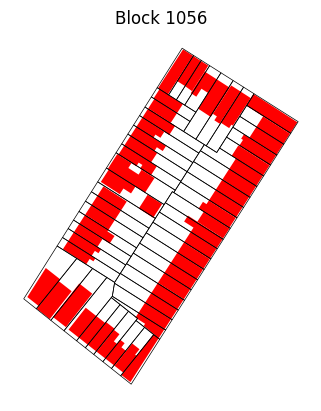

In [51]:
ax = sample_block_lots.boundary.plot(color="black", linewidth=0.5)
sample_block_bldgs.plot(ax=ax, color="red").set_axis_off()

ax.set_title(f"Block {sample_block}")

In [52]:
sample_block_non_bldg = sample_block_lots.difference(sample_block_bldgs.unary_union)

In [53]:
sample_block_non_bldg.shape

(54,)

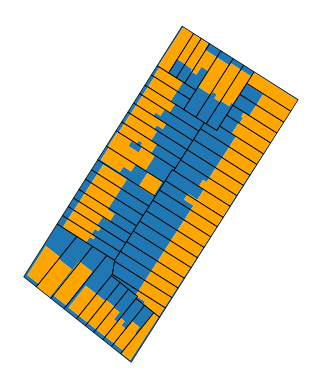

In [54]:
ax = sample_block_lots.boundary.plot(color="black", linewidth=0.5)
sample_block_non_bldg.plot(ax=ax)
sample_block_bldgs.plot(ax=ax, color="orange").set_axis_off()

In [55]:
sample_block_non_bldg_intersect = sample_block_lots.intersection(
    sample_block_bldgs.unary_union
)

In [56]:
sample_block_non_bldg_intersect.shape

(54,)

<Axes: >

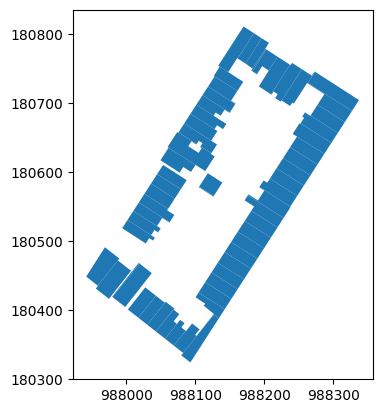

In [57]:
sample_block_non_bldg_intersect.plot()

## Union


In [58]:
sample_block_lots["lot_area"] = sample_block_lots.area

In [59]:
lots_bldgs_union = gpd.overlay(sample_block_lots, sample_block_bldgs, how="union")

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_70073/3882292701.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  lots_bldgs_union = gpd.overlay(sample_block_lots, sample_block_bldgs, how="union")


In [60]:
lots_bldgs_union.shape

(192, 114)

In [61]:
import pandas as pd

In [62]:
lots_bldgs_union

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,rep_pt,geometry
0,BK,1056.0,43.0,307.0,3014902,30149023003,149,5003,15,39.0,...,Constructed,2100,146,Photogramm,3024335,2017-08-22,315359,0.0,POINT (988156.711 180464.735),"POLYGON ((988170.951 180445.319, 988156.172 18..."
1,BK,1056.0,43.0,307.0,3014902,30149023003,149,5003,15,39.0,...,Constructed,2100,145,Photogramm,3024336,2017-08-22,365664,0.0,POINT (988147.156 180449.925),"POLYGON ((988132.590 180468.838, 988133.151 18..."
2,BK,1056.0,43.0,307.0,3014902,30149023003,149,5003,15,39.0,...,Constructed,2100,147,Photogramm,3024334,2017-08-22,410480,0.0,POINT (988166.185 180479.420),"POLYGON ((988180.538 180460.178, 988180.271 18..."
3,BK,1056.0,42.0,307.0,3014902,30149023003,149,5003,15,39.0,...,Constructed,2100,147,Photogramm,3024334,2017-08-22,410480,0.0,POINT (988166.185 180479.420),"POLYGON ((988188.017 180475.903, 988189.899 18..."
4,BK,1056.0,42.0,307.0,3014902,30149023003,149,5003,15,39.0,...,Constructed,2100,146,Photogramm,3024333,2017-08-22,805851,0.0,POINT (988175.664 180494.113),"POLYGON ((988189.909 180474.704, 988189.899 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Constructed,2100,148,Photogramm,3024323,2017-08-22,492641,0.0,POINT (988267.064 180649.686),"POLYGON ((988287.001 180626.617, 988241.172 18..."
188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Constructed,2100,146,Photogramm,3024333,2017-08-22,805851,0.0,POINT (988175.664 180494.113),"POLYGON ((988188.381 180475.672, 988189.909 18..."
189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Constructed,2100,141,Photogramm,3024318,2017-08-22,229224,0.0,POINT (988202.345 180760.649),"MULTIPOLYGON (((988191.976 180760.900, 988182...."
190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Alteration,2100,141,Other (Man,3024319,2023-03-30,440736,0.0,POINT (988216.035 180741.475),"MULTIPOLYGON (((988201.701 180739.833, 988214...."


<Axes: >

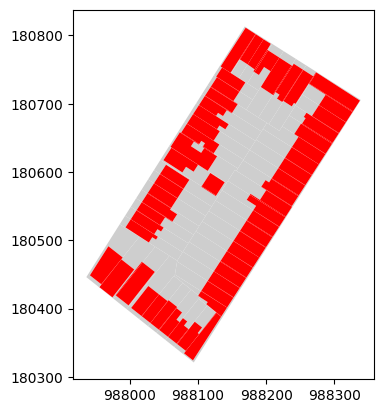

In [63]:
ax = lots_bldgs_union[lots_bldgs_union.globalid.isna()].plot(color="#cecece")
lots_bldgs_union[lots_bldgs_union.globalid.notna()].plot(ax=ax, color="red")

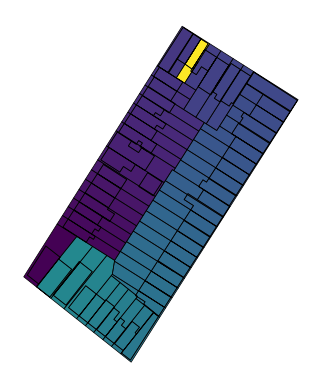

In [64]:
ax = lots_bldgs_union[lots_bldgs_union.globalid.isna()].plot("Lot")
lots_bldgs_union[lots_bldgs_union.globalid.notna()].plot("Lot", ax=ax)
lots_bldgs_union.boundary.plot(color="black", ax=ax, linewidth=0.5).set_axis_off()

In [65]:
lots_bldgs_union.globalid.unique()

array(['{664BF849-8A16-4B2B-B366-9B0B8CE16D63}',
       '{F07A4C63-A9FD-4B6A-A000-1CAEB91FE7BD}',
       '{5DA374FD-46BD-4DFF-9734-379AFA42B395}',
       '{7B05048D-8DC1-4BB9-8BB9-0EF0EBA92FD0}',
       '{D19DE40A-A908-4A02-B6FC-43A35AA21241}',
       '{5F0E6BD1-4907-46BC-825A-A8CF44038B90}',
       '{8DB41682-066C-494C-9532-EA39692148DA}',
       '{98BF2394-2627-4072-9F74-D18C8D4C806C}',
       '{31A3D41E-AFF0-4B00-9DB9-CF9E423FB41D}',
       '{A8F87ED8-ECF1-4464-9E53-73F1C02FF274}',
       '{AD08BD1C-2AD0-4F3D-992C-3B6DC118F582}',
       '{0B3FBA10-9AB5-4297-A965-4F79BC981BC2}',
       '{CF7186F4-8886-4008-B9D7-8E932D801F77}',
       '{D6E5CDA2-0FF2-43D4-BD4A-FFE351DC2128}',
       '{16D60C70-F780-4A5B-8C9D-236CB66E4127}',
       '{7BB0CD7F-1D34-40E8-BF90-A083F3C85EFB}',
       '{052FC251-D507-420D-A556-F0A392AE2237}',
       '{C7792D8D-8658-47CC-B735-8D889A61E024}',
       '{61A2E7E2-AED6-4AE2-9237-FEC55CEF4809}',
       '{D20B3BD1-B249-40F6-A6E6-2271811B93EB}',
       '{A2CAA298-7A

In [66]:
lots_bldgs_union["pct_bldg_lot_coverage"] = lots_bldgs_union.apply(
    lambda x: ((x.geometry.area / x.lot_area) * 100 if type(x.globalid) == str else -1),
    axis=1,
)

<Axes: >

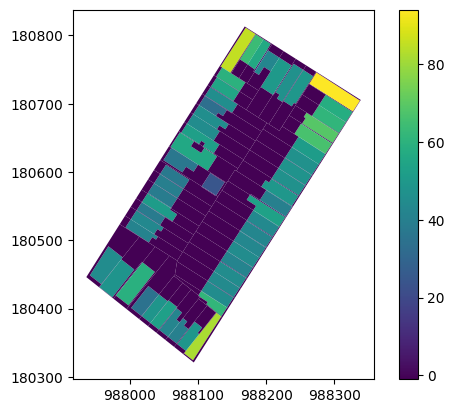

In [67]:
lots_bldgs_union.plot("pct_bldg_lot_coverage", legend=True)

## calculate soft sites (create new attributes)


In [68]:
def is_soft_site(r, threshold=0.33):
    if (
        r.BuiltFAR <= r.ResidFAR * threshold
        and r.LotArea > 10000
        and r.LandUse != "Open Space & Outdoor Recreation"
        and r.ResidFAR > 0
    ):
        return 1
    else:
        return 0

In [69]:
cb_307["soft_site"] = cb_307.apply(is_soft_site, axis=1)

In [70]:
cb_307["soft_site"].value_counts()

soft_site
0    13251
1       33
Name: count, dtype: int64

<Axes: >

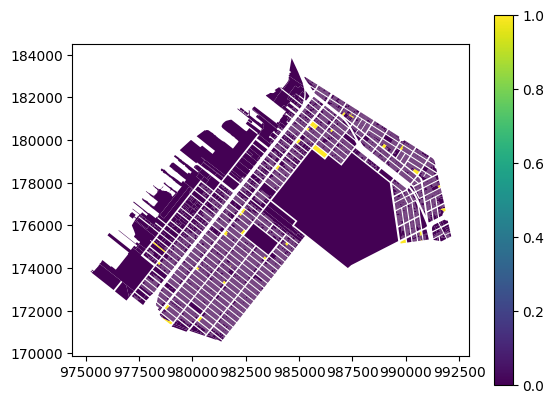

In [71]:
cb_307.plot("soft_site", legend=True)

In [72]:
cb_307[cb_307.soft_site.eq(1)][["soft_site", "BuiltFAR", "ResidFAR"]]

,soft_site,BuiltFAR,ResidFAR
116,1,0.05,1.25
125,1,0.69,2.43
529,1,0.18,4.00
538,1,0.59,3.00
796,1,0.41,1.35
1642,1,0.97,6.02
1656,1,0.09,2.00
1696,1,0.00,6.02
1738,1,0.40,2.00
1905,1,0.32,2.00
